In [1]:
import os

os.environ['CRDS_PATH'] = './crds_cache'
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import stdatamodels.jwst.datamodels as dm
from glob import glob
from astropy.visualization import ZScaleInterval
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.table import Table
from jwst.extract_1d import Extract1dStep as x1d

In [9]:
path = "./mastDownload/JWST/CEERS-NIRSPEC-P7-PRISM-MSATA/Final/jw01345-o065_s23642_nirspec_clear-prism_s2d.fits"

def changeUnit(bunit,sr):
    if bunit == "MJy":
        unit = "Jy"
        _ = 1e6
    elif bunit == "MJy/sr":
        unit = "Jy"
        _ = sr * 1e6
    else:
        unit = bunit
        _ = 1

    return _, unit

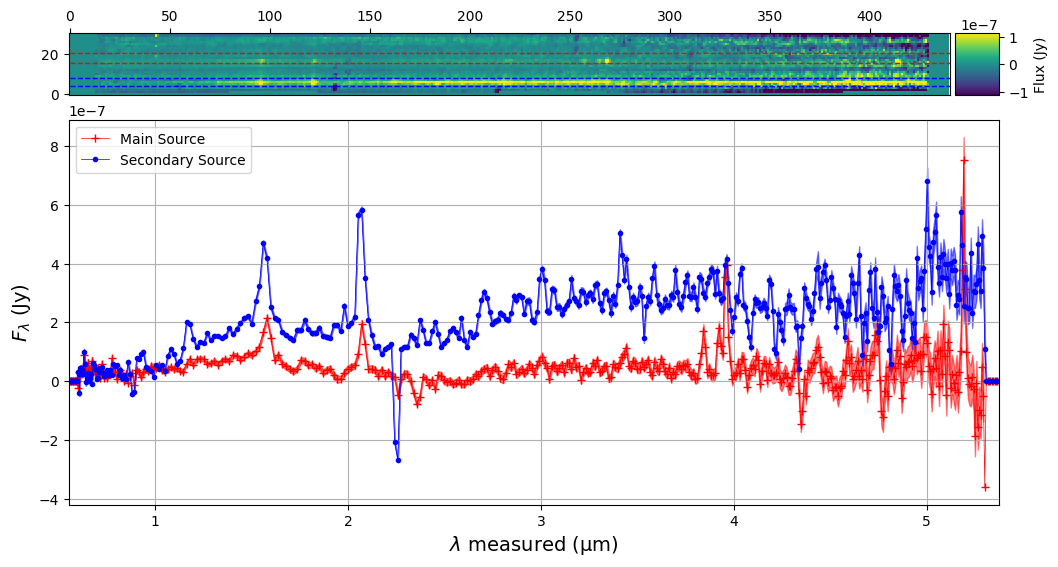

0.18468573880369502


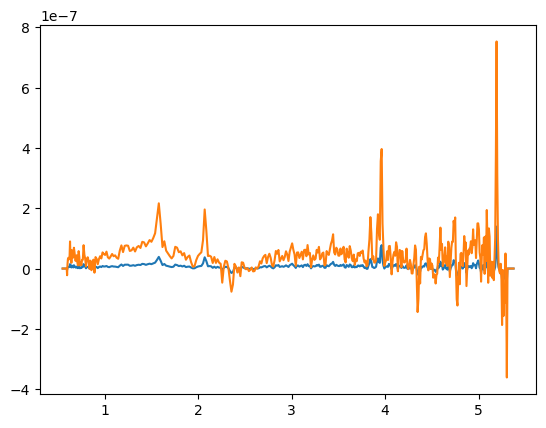

In [32]:
with dm.open(path) as mos:
    with fits.open(path.replace("_s2d.fits", "_x1d.fits")) as hdul:
        wave_src = hdul[1].data["WAVELENGTH"]
        flux_src = hdul[1].data["FLUX"]
        dflux_src = hdul[1].data["FLUX_ERROR"]
        ymin, ymax = hdul[1].header["EXTRYSTR"], hdul[1].header["EXTRYSTP"]
        unitx1d = hdul[1].header["TUNIT2"]
        
    with fits.open(path.replace("prism_s2d.fits", "prism1_x1d.fits")) as hdul:
        coeff = 0.18468573880369502
        wave_2 = hdul[1].data["WAVELENGTH"]
        flux_2 = hdul[1].data["FLUX"] / coeff
        dflux_2 = hdul[1].data["FLUX_ERROR"]

    # Convert data to Jy
    data = np.copy(mos.data)
    factor, unit = changeUnit(mos.meta.bunit_data,mos.meta.photometry.pixelarea_steradians)
    data *= factor

    # Z scale algorithm
    z = ZScaleInterval()
    z1, z2 = z.get_limits(data)

    # The 2D plot
    fig, ax = plt.subplots(2, figsize=(12, 10), gridspec_kw={'hspace': 0})
    fig.subplots_adjust(hspace=0)
    im = ax[0].imshow(data, interpolation='None', origin="lower", vmin=z1, vmax=z2)
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical', label=f"Flux ({unitx1d})")

    # Visual slice
    ax[0].hlines((ymin, ymax), 0, data.shape[1], color='r', linewidth=1, linestyle='dashed')
    yExtract = 6
    n = 2
    ax[0].hlines((yExtract-n, yExtract+n), 0, data.shape[1], color='b', linewidth=1, linestyle='dashed')
    ax[0].xaxis.set_ticks_position('top')
    ax[0].xaxis.set_label_position('top')
    ax[0].margins(x=0)

    # The spectrum plot
    ax[1].plot(wave_src, flux_src, marker='+', color="r", linewidth=0.5, label="Main Source")
    ax[1].fill_between(wave_src, flux_src + dflux_src, flux_src - dflux_src, color='red', alpha=0.5)
    ax[1].plot(wave_2, flux_2, marker='.', color="blue", linewidth=0.5, label="Secondary Source")
    ax[1].fill_between(wave_2, flux_2 + dflux_2, flux_2 - dflux_2, color='blue', alpha=0.5)
    ax[1].grid(True)
    ax[1].set_xlabel(r"$\lambda$ measured (µm)", fontsize=14)
    ax[1].set_ylabel(fr"$F_\lambda$ ({unit})", fontsize=14)
    ax[1].margins(x=0)
    ax[1].legend()

    # bounding box
    box = ax[1].get_position()
    box.y0 += 0.137
    box.y1 += 0.137
    ax[1].set_position(box)

    plt.show()
    
    Y, X = np.indices(data.shape)
    _, _, lamb = mos.meta.wcs.transform("detector", "world", X, Y)
    wave = lamb[round(ymin):round(ymax)].mean(axis=0)
    flux = data[round(ymin):round(ymax)].mean(axis=0)
    dflux = np.sqrt((mos.err[round(ymin):round(ymax)]**2).mean(axis=0)) * factor
    
    plt.figure()
    plt.plot(wave,flux)
    plt.plot(wave_src,flux_src)
    print(flux.max()/flux_src.max())
    plt.show()

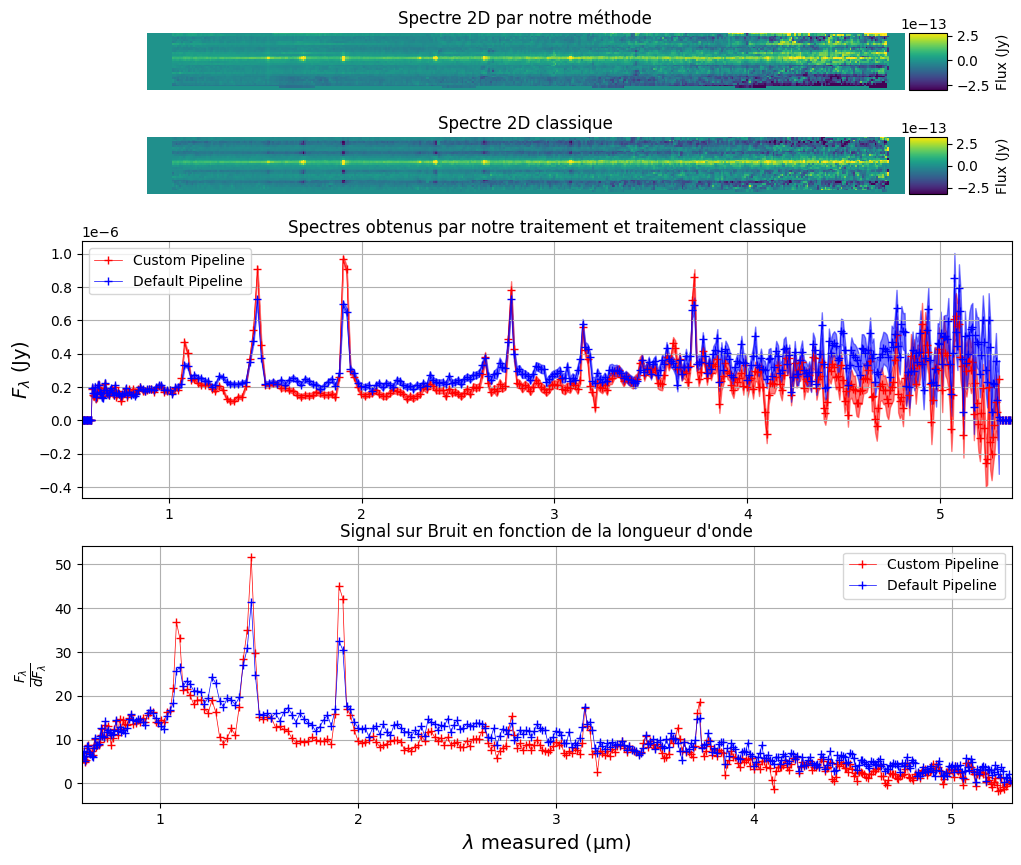

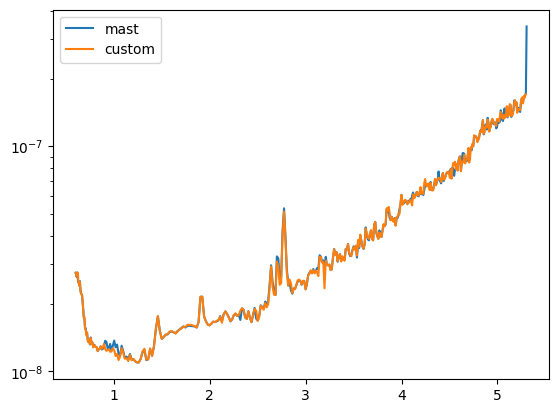

In [85]:
path = "./mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/Final/jw01345-o063_s32304_nirspec_clear-prism_s2d.fits"

# Function to change unit (assume this function is defined elsewhere)
def changeUnit(bunit_data, pixelarea_steradians):
    # Placeholder implementation
    return 1, 'Jy'

with dm.open(path) as mos:
    # Convert data to Jy
    data_me = np.copy(mos.data)
    factor, unit_me = changeUnit(mos.meta.bunit_data, mos.meta.photometry.pixelarea_steradians)
    data_me *= factor
    
with dm.open(path.replace("Final", "Mast")) as mos:
    # Convert data to Jy
    data_mast = np.copy(mos.data)
    factor, unit_mast = changeUnit(mos.meta.bunit_data, mos.meta.photometry.pixelarea_steradians)
    data_mast *= factor

# Create figure and grid specification
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(4, 1, height_ratios=[1, 1, 4.5, 4.5],hspace=0.3)

# First plot
ax1 = fig.add_subplot(gs[0])
z1, z2 = ZScaleInterval().get_limits(data_me)
im1 = ax1.imshow(data_me, interpolation='None', origin="lower", vmin=z1, vmax=z2)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical', label=f"Flux ({unit_me})")
ax1.set_axis_off()
ax1.set_title("Spectre 2D par notre méthode")

# Second plot
ax2 = fig.add_subplot(gs[1])
z1, z2 = ZScaleInterval().get_limits(data_mast)
im2 = ax2.imshow(data_mast, interpolation='None', origin="lower", vmin=z1, vmax=z2)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical', label=f"Flux ({unit_mast})")
ax2.set_axis_off()
ax2.set_title("Spectre 2D classique")

# Load spectral data
with fits.open(path.replace("s2d", "x1d")) as hdul:
    wave_me = hdul[1].data["WAVELENGTH"]
    flux_me = hdul[1].data["FLUX"]
    dflux_me = hdul[1].data["FLUX_ERROR"]

with fits.open(path.replace("s2d", "x1d").replace("Final", "Mast")) as hdul:
    wave_mast = hdul[1].data["WAVELENGTH"]
    flux_mast = hdul[1].data["FLUX"]
    dflux_mast = hdul[1].data["FLUX_ERROR"]

# Third plot
ax3 = fig.add_subplot(gs[2])
ax3.plot(wave_me, flux_me, marker='+', color="r", linewidth=0.5, label="Custom Pipeline")
ax3.fill_between(wave_me, flux_me + dflux_me, flux_me - dflux_me, color='r', alpha=0.5)
ax3.plot(wave_mast, flux_mast, marker='+', color="b", linewidth=0.5, label="Default Pipeline")
ax3.fill_between(wave_mast, flux_mast + dflux_mast, flux_mast - dflux_mast, color='b', alpha=0.5)
ax3.legend()
ax3.grid(True)
ax3.set_ylabel(fr"$F_\lambda$ ({unit_me})", fontsize=14)
ax3.set_title("Spectres obtenus par notre traitement et traitement classique")
ax3.margins(x=0)

# Fourth plot
ax4 = fig.add_subplot(gs[3])
ax4.plot(wave_me, flux_me/dflux_me, marker='+', color="r", linewidth=0.5, label="Custom Pipeline")
ax4.plot(wave_mast, flux_mast/dflux_mast, marker='+', color="b", linewidth=0.5, label="Default Pipeline")
ax4.legend()
ax4.grid(True)
ax4.set_xlabel(r"$\lambda$ measured (µm)", fontsize=14)
ax4.set_ylabel(r"$\frac{F_\lambda}{dF_\lambda}$", fontsize=14)
ax4.set_title("Signal sur Bruit en fonction de la longueur d'onde")
ax4.margins(x=0)

plt.show()

plt.figure()
plt.plot(wave_mast,dflux_mast,label="mast")
plt.plot(wave_me,dflux_me,label="custom")
plt.legend()
plt.yscale("log")
plt.show()